In [156]:
# Import libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import unicodedata
import re
import nltk
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.corpus import stopwords

import os
import json
from typing import Dict, List, Optional, Union, cast
import requests

from env import github_token, github_username
import acquire, prep, model

In [113]:
# plotting defaults

plt.rc('figure', figsize=(13, 7))
plt.style.use('seaborn-whitegrid')
plt.rc('font', size=16)

## Acquire README Dataset

In [265]:
# Load the data from json file
df = pd.read_json('data.json')

# Print the shape of the df
print(df.shape)

# Take a peek at the dataset
df.head()

(105, 3)


,repo,language,readme_contents
0,freeCodeCamp/chapter,TypeScript,# Welcome to Chapter\n[![All Contributors](htt...
1,freeCodeCamp/freeCodeCamp,JavaScript,![freeCodeCamp.org Social Banner](https://s3.a...
2,freeCodeCamp/nginx-config,None,# nginx-config\n\nConfig for our NGINX instanc...
3,freeCodeCamp/chat-config,HTML,Usage:\n\n1. Create a .env\n\n ```txt\n RO...
4,freeCodeCamp/devdocs,Ruby,# [DevDocs](https://devdocs.io) — API Document...


In [266]:
# Quick summarize df
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 105 entries, 0 to 104
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   repo             105 non-null    object
 1   language         97 non-null     object
 2   readme_contents  99 non-null     object
dtypes: object(3)
memory usage: 3.3+ KB


**Takeaways**
- Missing values are found in the columns 'language' and 'readme_contents'.
- For MVP, we decide to drop the records with missing values. 

## Wrangle README Datasets

In [267]:
# Drop the missing values
df = df.dropna()

# Print the shape of the df
df.shape

(92, 3)

In [268]:
# Clean the text by helper function
# Exlude words: 'freecodecamp', 'repository', 'run', 'test', 'use', 'using'
df = prep.prep_data(df, 'readme_contents', 
                    extra_words=['freecodecamp', 'repository', 'run', 'test', 'use', 'using'],
                    exclude_words=[])

# Print the shape
print(df.shape)

# Take a peek at the clean data
df.head()

(92, 6)


,repo,language,readme_contents,stemmed,lemmatized,clean
0,freeCodeCamp/chapter,TypeScript,# Welcome to Chapter\n[![All Contributors](htt...,welcom to chapter all contributorshttpsimgshie...,welcome to chapter all contributorshttpsimgshi...,welcome chapter contributorshttpsimgshieldsiob...
1,freeCodeCamp/freeCodeCamp,JavaScript,![freeCodeCamp.org Social Banner](https://s3.a...,freecodecamporg social bannerhttpss3amazonawsc...,freecodecamporg social bannerhttpss3amazonawsc...,freecodecamporg social bannerhttpss3amazonawsc...
3,freeCodeCamp/chat-config,HTML,Usage:\n\n1. Create a .env\n\n ```txt\n RO...,usag 1 creat a env txt rocketchat_versionlates...,usage 1 create a env txt rocketchat_versionlat...,usage 1 create env txt rocketchat_versionlates...
4,freeCodeCamp/devdocs,Ruby,# [DevDocs](https://devdocs.io) — API Document...,devdocshttpsdevdocsio api document browser bui...,devdocshttpsdevdocsio api documentation browse...,devdocshttpsdevdocsio api documentation browse...
5,freeCodeCamp/news-theme,Handlebars,![freeCodeCamp.org Social Banner](https://s3.a...,freecodecamporg social bannerhttpss3amazonawsc...,freecodecamporg social bannerhttpss3amazonawsc...,freecodecamporg social bannerhttpss3amazonawsc...


In [269]:
# Quick summarize dataset

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 92 entries, 0 to 104
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   repo             92 non-null     object
 1   language         92 non-null     object
 2   readme_contents  92 non-null     object
 3   stemmed          92 non-null     object
 4   lemmatized       92 non-null     object
 5   clean            92 non-null     object
dtypes: object(6)
memory usage: 5.0+ KB


## Quick Exploration
- Detailed Exploration could be find in the autin_scratch.ipynb

In [270]:
# Compute the relative frequency in each language
df.language.value_counts(normalize=True)

JavaScript    0.543478
Python        0.141304
HTML          0.130435
CSS           0.065217
Shell         0.032609
TypeScript    0.021739
R             0.021739
Ruby          0.021739
SCSS          0.010870
Handlebars    0.010870
Name: language, dtype: float64

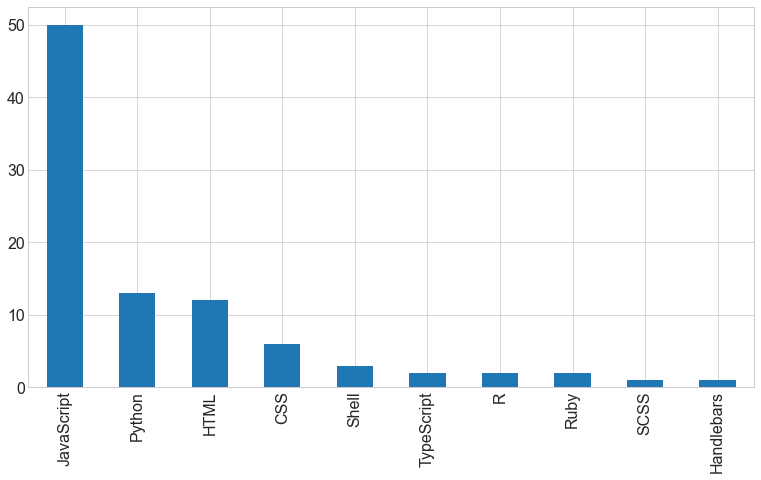

In [271]:
# Viz the distribution of the languages

df.language.value_counts().plot(kind='bar')
plt.show()

**Takeaways**
- About half of the languages are written in JavaScript. 

## Additional Wrangling

In [272]:
# Convert languages into js or not
df.language = df.language.apply(lambda i: 'js' if i == 'JavaScript' else 'other')

In [273]:
# Take a peek at the df
df.head()

,repo,language,readme_contents,stemmed,lemmatized,clean
0,freeCodeCamp/chapter,other,# Welcome to Chapter\n[![All Contributors](htt...,welcom to chapter all contributorshttpsimgshie...,welcome to chapter all contributorshttpsimgshi...,welcome chapter contributorshttpsimgshieldsiob...
1,freeCodeCamp/freeCodeCamp,js,![freeCodeCamp.org Social Banner](https://s3.a...,freecodecamporg social bannerhttpss3amazonawsc...,freecodecamporg social bannerhttpss3amazonawsc...,freecodecamporg social bannerhttpss3amazonawsc...
3,freeCodeCamp/chat-config,other,Usage:\n\n1. Create a .env\n\n ```txt\n RO...,usag 1 creat a env txt rocketchat_versionlates...,usage 1 create a env txt rocketchat_versionlat...,usage 1 create env txt rocketchat_versionlates...
4,freeCodeCamp/devdocs,other,# [DevDocs](https://devdocs.io) — API Document...,devdocshttpsdevdocsio api document browser bui...,devdocshttpsdevdocsio api documentation browse...,devdocshttpsdevdocsio api documentation browse...
5,freeCodeCamp/news-theme,other,![freeCodeCamp.org Social Banner](https://s3.a...,freecodecamporg social bannerhttpss3amazonawsc...,freecodecamporg social bannerhttpss3amazonawsc...,freecodecamporg social bannerhttpss3amazonawsc...


In [274]:
# Add column words

df['words'] = [re.sub(r'([^a-z0-9\s]|\s.\s)', '', doc)\
               .split() for doc in df.lemmatized]

# Take a peek at the new df
df.head(2)

,repo,language,readme_contents,stemmed,lemmatized,clean,words
0,freeCodeCamp/chapter,other,# Welcome to Chapter\n[![All Contributors](htt...,welcom to chapter all contributorshttpsimgshie...,welcome to chapter all contributorshttpsimgshi...,welcome chapter contributorshttpsimgshieldsiob...,"[welcome, to, chapter, all, contributorshttpsi..."
1,freeCodeCamp/freeCodeCamp,js,![freeCodeCamp.org Social Banner](https://s3.a...,freecodecamporg social bannerhttpss3amazonawsc...,freecodecamporg social bannerhttpss3amazonawsc...,freecodecamporg social bannerhttpss3amazonawsc...,"[freecodecamporg, social, bannerhttpss3amazona..."


In [275]:
# Drop the column repo
df.drop(columns = 'repo', inplace=True)

# Take a peek at the df
df.head(1)

,language,readme_contents,stemmed,lemmatized,clean,words
0,other,# Welcome to Chapter\n[![All Contributors](htt...,welcom to chapter all contributorshttpsimgshie...,welcome to chapter all contributorshttpsimgshi...,welcome chapter contributorshttpsimgshieldsiob...,"[welcome, to, chapter, all, contributorshttpsi..."


In [276]:
# Drop the stemmed column
df.drop(columns='stemmed', inplace=True)

# Take a peek at the df
df.head(1)

,language,readme_contents,lemmatized,clean,words
0,other,# Welcome to Chapter\n[![All Contributors](htt...,welcome to chapter all contributorshttpsimgshi...,welcome chapter contributorshttpsimgshieldsiob...,"[welcome, to, chapter, all, contributorshttpsi..."


In [277]:
# Rename the columns
df.columns = ['label', 'text', 'lemmatized', 'clean', 'words']

# Take a peek at the df
df.head(1)

,label,text,lemmatized,clean,words
0,other,# Welcome to Chapter\n[![All Contributors](htt...,welcome to chapter all contributorshttpsimgshi...,welcome chapter contributorshttpsimgshieldsiob...,"[welcome, to, chapter, all, contributorshttpsi..."


## Modeling
### Goal: to predict the language used for the repo is JavaScript or not (binary classification).

#### Split into train and validate

In [278]:
from sklearn.model_selection import train_test_split

train, validate = train_test_split(df[['label', 'clean']], 
                                   stratify=df.label, 
                                   test_size=.2,
                                   random_state=123)

In [279]:
print(train.label.value_counts())
print(validate.label.value_counts())
train.head()

js       40
other    33
Name: label, dtype: int64
js       10
other     9
Name: label, dtype: int64


,label,clean
78,js,longer please search mono repohttpsgithubcomfr...
69,js,open source good directory directory freecodec...
3,other,usage 1 create env txt rocketchat_versionlates...
73,other,happy new year 2017 simple website host open20...
86,js,pm2 pager get notification exception pm2 nodem...


#### Compute the baseline accuracy

In [280]:
labels = pd.concat([train.label.value_counts(), # get total counts of js vs other
                    train.label.value_counts(normalize=True)], axis=1) # getting the prop of js vs other
labels.columns = ['n', 'percent']
labels

,n,percent
js,40,0.547945
other,33,0.452055


**Takeaway**:
- The baseline accuracy is 55%. 

### Feature Generation: Bag of Words

In [133]:
from sklearn.feature_extraction.text import CountVectorizer

# Create CountVectorizer, which create bag-of-words model.
# stop_words : Specify language to remove stopwords. 
# min_df: ignore terms that have a document frequency strictly 
# lower than the given threshold. This value is also called cut-off in the literature. 
# If float, the parameter represents a proportion of documents, integer absolute counts. 
# ngram_range: the lower and upper boundary of the range of n-values for 
# different word n-grams or char n-grams to be extracted. 

vectorizer = CountVectorizer(stop_words='english', 
                             min_df=10, 
                             ngram_range=(1,2), 
                             binary=True)

# Learn vocabulary in sentences. 
vectorizer.fit(train.clean)

# Get dictionary. 
vectorizer.get_feature_names()

['add',
 'api',
 'automatically',
 'available',
 'build',
 'button',
 'check',
 'click',
 'code',
 'contributing',
 'convenience',
 'copy',
 'create',
 'curriculum',
 'data',
 'development',
 'example',
 'file',
 'following',
 'function',
 'github',
 'help',
 'imported',
 'information',
 'install',
 'issue',
 'license',
 'like',
 'make',
 'new',
 'npm',
 'npm install',
 'open',
 'page',
 'project',
 'pull',
 'request',
 'return',
 'set',
 'source',
 'start',
 'submit',
 'submitting',
 'sure',
 'test',
 'test automatically',
 'testing',
 'time',
 'unit',
 'unit test',
 'url',
 'user',
 'work']

In [134]:
# Transform each sentences in vector space.
bow = vectorizer.transform(train.clean)

In [135]:
# this is just to see the array of 0's and 1's
bow_array = bow.toarray()
bow_array[0]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0])

In [136]:
# Show sentences and vector space representation.
# purely to visualize what's happening.
for i, v in zip(train.clean, bow_array):
    print(i)
    print(v)

longer please search mono repohttpsgithubcomfreecodecampsearchmonorepo instead happy coding
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
open source good directory directory freecodecamps open source good apps solution nonprofit instruction adding nonprofit project two step add open source good project directory 1 add file osfgdirconfigjs root project trigger automatic build project page inside directory please verify update camperbot docsprojectname occurred master branch directory field title displayed top webpage title demovideo youtube video address livedemo address project homepage description es6 template string contains githubflavored markdown keep relatively short paragraph top body es6 template string githubflavored markdown please include open source license copyright end livedemo demovideo arent yet available exclued wont added project page see sample config filehttpsgithubcomfreecodecampopensourceforgooddirecto

In [137]:
# Change the name
X_bow = bow

### Feature Generation: TF-IDF

In [139]:
# Transform the clean text into sparse matrix

from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(stop_words='english', min_df=10, 
                             ngram_range=(1,2), 
                             binary=True)

tfidf_sparse_matrix = tfidf.fit_transform(train.clean)
tfidf_sparse_matrix

<73x53 sparse matrix of type '<class 'numpy.float64'>'
	with 733 stored elements in Compressed Sparse Row format>

In [140]:
# Conver to datafame
pd.DataFrame(tfidf_sparse_matrix.todense(), columns=tfidf.get_feature_names())

,add,api,automatically,available,build,button,check,click,code,contributing,...,sure,test,test automatically,testing,time,unit,unit test,url,user,work
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.192645,0.000000,0.211945,0.237266,0.197059,0.000000,0.000000,0.000000,0.180676,0.0,...,0.230162,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.211945,0.223628
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
69,0.000000,0.251397,0.000000,0.259156,0.000000,0.000000,0.244259,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.231499,0.000000,0.000000,0.000000,0.000000,0.231499,0.244259
70,0.167895,0.000000,0.184715,0.000000,0.000000,0.206783,0.000000,0.206783,0.157463,0.0,...,0.200592,0.160774,0.206783,0.184715,0.200592,0.206783,0.206783,0.180122,0.000000,0.000000
71,0.000000,0.000000,0.000000,0.727713,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [141]:
# Get vocabularies.
tfidf.vocabulary_

{'open': 32,
 'source': 39,
 'project': 34,
 'add': 0,
 'file': 17,
 'build': 4,
 'page': 33,
 'license': 26,
 'available': 3,
 'github': 20,
 'data': 14,
 'request': 36,
 'user': 51,
 'make': 28,
 'sure': 43,
 'npm': 30,
 'install': 24,
 'create': 12,
 'work': 52,
 'following': 18,
 'automatically': 2,
 'code': 8,
 'npm install': 31,
 'new': 29,
 'api': 1,
 'example': 16,
 'time': 47,
 'unit': 48,
 'test': 44,
 'issue': 25,
 'start': 40,
 'contributing': 9,
 'submitting': 42,
 'pull': 35,
 'unit test': 49,
 'like': 27,
 'set': 38,
 'development': 15,
 'function': 19,
 'click': 7,
 'button': 5,
 'testing': 46,
 'imported': 22,
 'convenience': 10,
 'copy': 11,
 'url': 50,
 'submit': 41,
 'information': 23,
 'test automatically': 45,
 'check': 6,
 'return': 37,
 'help': 21,
 'curriculum': 13}

In [142]:
# Transform to document-term matrix
vector_spaces = tfidf.transform(train.clean)
vector_spaces.toarray()

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.1926452 , 0.        , 0.21194451, ..., 0.        , 0.21194451,
        0.22362758],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.16789477, 0.        , 0.18471457, ..., 0.18012245, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.38661272]])

In [143]:
# Show sentences and vector space representation.
# 
# (A, B) C
# A : Document Index
# B : Specific word-vector index
# C : TF-IDF score
for i, v in zip(train.clean, vector_spaces):
    print(i)
    print(v)

longer please search mono repohttpsgithubcomfreecodecampsearchmonorepo instead happy coding

open source good directory directory freecodecamps open source good apps solution nonprofit instruction adding nonprofit project two step add open source good project directory 1 add file osfgdirconfigjs root project trigger automatic build project page inside directory please verify update camperbot docsprojectname occurred master branch directory field title displayed top webpage title demovideo youtube video address livedemo address project homepage description es6 template string contains githubflavored markdown keep relatively short paragraph top body es6 template string githubflavored markdown please include open source license copyright end livedemo demovideo arent yet available exclued wont added project page see sample config filehttpsgithubcomfreecodecampopensourceforgooddirectoryblobmasterosfgdirconfigjs root 2 edit file repolistjson root directory include project file tell directory

In [144]:
# Rename the train features
X_tfidf = tfidf_sparse_matrix

### Model on Train using LogisticRegression

In [145]:
# create our y dataset
y = train['label']

X_bow, X_tfidf

(<73x53 sparse matrix of type '<class 'numpy.int64'>'
 	with 733 stored elements in Compressed Sparse Row format>,
 <73x53 sparse matrix of type '<class 'numpy.float64'>'
 	with 733 stored elements in Compressed Sparse Row format>)

#### Model on X_bow

In [146]:
from sklearn.linear_model import LogisticRegression

# Create the LogisticRegressioin object and fit on train
lm = LogisticRegression().fit(X_bow, y)

# Predict the labels for the train
train['predicted'] = lm.predict(X_bow)

In [147]:
# Compute the confusion matrix

from sklearn.metrics import confusion_matrix, classification_report
confusion_matrix(train.label, train.predicted)

array([[39,  1],
       [13, 20]])

In [148]:
# Compute the performance metrics
print(classification_report(train.label, train.predicted))

              precision    recall  f1-score   support

          js       0.75      0.97      0.85        40
       other       0.95      0.61      0.74        33

    accuracy                           0.81        73
   macro avg       0.85      0.79      0.79        73
weighted avg       0.84      0.81      0.80        73



**Takeaways**
- when min_df = 20: 
    - The accuracy is 67%, which beats the baseline 
    - The lm performs better on predicting the JavaScript than other language.
- when min_df = 10:
    - The accuracy is 81%, which get improved by 14%. 

#### Model TFIDF

In [149]:
# Fit the LogisticRegression on TFIDF features
lm_tfidf = LogisticRegression().fit(X_tfidf, y)

# Predic the labels
train['pred_tfidf'] = lm_tfidf.predict(X_tfidf)

In [150]:
# Compute the confusion matrix
confusion_matrix(train.label, train.pred_tfidf)

array([[39,  1],
       [17, 16]])

In [151]:
# Compute the performance metrics
print(classification_report(train.label, train.pred_tfidf))

              precision    recall  f1-score   support

          js       0.70      0.97      0.81        40
       other       0.94      0.48      0.64        33

    accuracy                           0.75        73
   macro avg       0.82      0.73      0.73        73
weighted avg       0.81      0.75      0.73        73



**Takeaways**
- When min_df = 20
    - The accuracy is 0.64, which also beats the baseline.
    - Simiar to bow features, the lm performs better on predicting the JavaScript than other language.
- When min_df = 10
    - The accuracy is 0.75, which get improved by 10%. 

### Model on Validate

In [152]:
# Create the bow and tfidf features for the validate

X_bow_validate = vectorizer.transform(validate.clean)
X_tfidf_validate = tfidf.transform(validate.clean)

In [153]:
# Predict the labels basded on both features. 

validate['predicted'] = lm.predict(X_bow_validate)
validate['pred_tfidf'] = lm_tfidf.predict(X_tfidf_validate)

In [154]:
# Compute the performance metrics for bow features. 
print(classification_report(validate.label, validate.predicted))

              precision    recall  f1-score   support

          js       0.62      0.80      0.70        10
       other       0.67      0.44      0.53         9

    accuracy                           0.63        19
   macro avg       0.64      0.62      0.61        19
weighted avg       0.64      0.63      0.62        19



In [155]:
# Compute the performance metrics for tfidf features.
print(classification_report(validate.label, validate.pred_tfidf))

              precision    recall  f1-score   support

          js       0.62      0.80      0.70        10
       other       0.67      0.44      0.53         9

    accuracy                           0.63        19
   macro avg       0.64      0.62      0.61        19
weighted avg       0.64      0.63      0.62        19



**Takeaways**
- The accuracy drops back to 63% for bow features and below the baseline for tfidf features, which indicates overfitting issue but still beats the baseline.
- Other metrics such as precision and recall drop about by 10-20%.

**Future Works**:
1. To enlarge the dataset.
2. Try different classification algorithms.
3. To exclude the 'run', 'repository' and similar words to reduce the noise. 

### How does the min_df affect the model performance?

In [281]:
# Loop through 

metrics = []
lr = LogisticRegression()

for i in range (5, 21):
    vectorizer = CountVectorizer(stop_words='english', 
                                 min_df=i, 
                                 ngram_range=(1,2), 
                                 binary=True)
    vectorizer = vectorizer.fit(train.clean)
    X_train = vectorizer.transform(train.clean)
    X_validate = vectorizer.transform(validate.clean)
    lr = lr.fit(X_train, y)
    y_pred_train = lr.predict(X_train)
    y_pred_validate = lr.predict(X_validate)
    d1 = model.estimator_report(i, 'train', train.label, y_pred_train)
    metrics.append(d1)
    d2 = model.estimator_report(i, 'validate', validate.label, y_pred_validate)
    metrics.append(d2)

In [282]:
# Conver the metrics into dataframe

metrics = pd.DataFrame(metrics)
metrics.head()

,model_type,data_type,accuracy,precision,recall
0,5,train,0.958904,1.000000,0.909091
1,5,validate,0.736842,0.833333,0.555556
2,6,train,0.945205,1.000000,0.878788
3,6,validate,0.631579,0.666667,0.444444
4,7,train,0.904110,1.000000,0.787879


In [283]:
# Rename the columns
metrics.rename(columns={'model_type':'min_df'}, inplace=True)

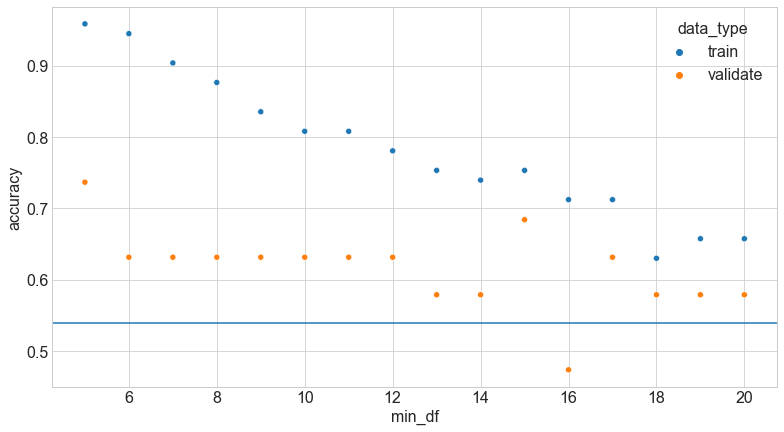

In [284]:
# Scatterplot the accuracy against the min_df 

sns.scatterplot(data=metrics, x='min_df', y='accuracy', hue='data_type')
plt.axhline(y=0.54)
plt.show()

In [288]:
feature_names14 = CountVectorizer(stop_words='english', 
                                 min_df=14, 
                                 ngram_range=(1,2), 
                                 binary=True).fit(train.clean).get_feature_names()

In [289]:
feature_names15 = CountVectorizer(stop_words='english', 
                                 min_df=15, 
                                 ngram_range=(1,2), 
                                 binary=True).fit(train.clean).get_feature_names()

In [291]:
set(feature_names14) - set(feature_names15)

{'automatically', 'copy', 'example', 'page', 'request', 'testing', 'user'}

### How does ngram_range affect the model performance?

In [292]:
# Loop through 

metrics = []
lr = LogisticRegression()

for i in range (2,6):
    vectorizer = CountVectorizer(stop_words='english', 
                                 min_df=15, 
                                 ngram_range=(1,i), 
                                 binary=True)
    print(vectorizer)
    vectorizer = vectorizer.fit(train.clean)
    X_train = vectorizer.transform(train.clean)
    X_validate = vectorizer.transform(validate.clean)
    lr = lr.fit(X_train, y)
    y_pred_train = lr.predict(X_train)
    y_pred_validate = lr.predict(X_validate)
    d1 = model.estimator_report(i, 'train', train.label, y_pred_train)
    metrics.append(d1)
    d2 = model.estimator_report(i, 'validate', validate.label, y_pred_validate)
    metrics.append(d2)

CountVectorizer(binary=True, min_df=15, ngram_range=(1, 2),
                stop_words='english')
CountVectorizer(binary=True, min_df=15, ngram_range=(1, 3),
                stop_words='english')
CountVectorizer(binary=True, min_df=15, ngram_range=(1, 4),
                stop_words='english')
CountVectorizer(binary=True, min_df=15, ngram_range=(1, 5),
                stop_words='english')


In [295]:
metrics = pd.DataFrame(metrics)
metrics

,model_type,data_type,accuracy,precision,recall
0,2,train,0.753425,0.826087,0.575758
1,2,validate,0.684211,0.714286,0.555556
2,3,train,0.753425,0.826087,0.575758
3,3,validate,0.684211,0.714286,0.555556
4,4,train,0.753425,0.826087,0.575758
5,4,validate,0.684211,0.714286,0.555556
6,5,train,0.753425,0.826087,0.575758
7,5,validate,0.684211,0.714286,0.555556


In [296]:
# Rename the columns
metrics.rename(columns={'model_type':'ngram_range'}, inplace=True)

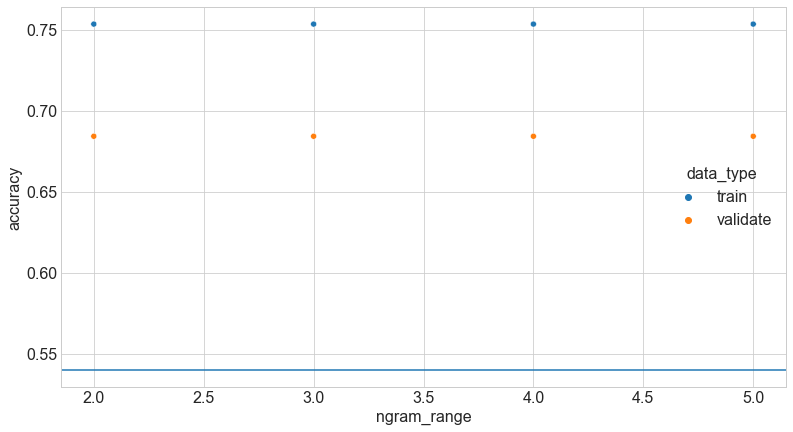

In [297]:
# Scatterplot the accuracy against the min_df 

sns.scatterplot(data=metrics, x='ngram_range', y='accuracy', hue='data_type')
plt.axhline(y=0.54)
plt.show()